In [1]:
%matplotlib notebook

In [2]:
# Purpose of this notebook: test LSTM model on SPY data 
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.core import Dense, Activation, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier


Using TensorFlow backend.


In [30]:
# convert p_t into a X,Y matrices for classification task
def create_dataset(p_t, dt_back=1):
    dataX, dataY = [], []
    
    for i in range(len(p_t)-dt_back-1):
        a = p_t[i:(i+dt_back), 0]
        dataX.append(a)
        dataY.append(p_t[i + dt_back, 0])
    # end for i
    
    # reshape X to be in the form [samples, time steps, features] - standard input for LSTM
    X=np.array(dataX)
    X = np.reshape(X,(X.shape[0],X.shape[1],1))  
    
    return X, np.array(dataY)
#end def create_dataset

In [4]:
# fix random seed for reproducibility
np.random.seed(7)

# load the p_t
df = read_csv('sp500.csv', usecols=[0], engine='python', skipfooter=3)
p_t = df.values       
p_t = p_t.astype('float32')

In [5]:
#p_t.shape   #df.values

In [6]:
# normalize the p_t
scaler = MinMaxScaler(feature_range=(0, 1))
p_t = scaler.fit_transform(p_t)

# split into train and test sets
N_train = int(len(p_t) * 0.67)
N_test = len(p_t) - N_train
train, test = p_t[0:N_train,:], p_t[N_train:len(p_t),:]

In [31]:
# reshape into X=t and Y=t+1
dt_back = 30     # look back time period
trainX, trainY = create_dataset(train, dt_back);  testX, testY = create_dataset(test, dt_back);

# reshape input to be [samples, time steps, features]
#trainX = np.reshape(trainX,(trainX.shape[0],trainX.shape[1],1))   # (trainX.shape[0], 1, trainX.shape[1])
#testX = np.reshape(testX,(testX.shape[0]create_dataset,testX.shape[1],1))   # (testX.shape[0], 1, testX.shape[1])

In [32]:
print(trainX.shape,trainY.shape)   #trainX.shape

(2746, 30, 1) (2746,)


In [11]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(100, input_shape=(dt_back,1)))   # input_shape=(1, dt_back)
model.add(Dense(1))

# compile and fit the model
model.compile(loss='mean_squared_error', optimizer='adam')


In [13]:
# perform batch-size parameter sweep to pick the best one
f_lp=0;   # 0=turns off the for loop below; make it 1, if you want to run it

for Nb in range(1,f_lp*64):    # (7,64):   # Nb=batch-size
    print('------ batch_size=',Nb)
    model = Sequential()
    model.add(LSTM(100, input_shape=(dt_back,1)))   # input_shape=(1, dt_back)
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=5, batch_size=Nb, verbose=2)

    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    # invert predictions
    p_train_pred_t = scaler.inverse_transform(trainPredict); trainY1 = scaler.inverse_transform([trainY]);    
    p_test_pred_t = scaler.inverse_transform(testPredict);   testY1 = scaler.inverse_transform([testY]);

    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY1[0], p_train_pred_t[:,0]))    
    testScore = math.sqrt(mean_squared_error(testY1[0], p_test_pred_t[:,0]))
    
    print('Train Score: %.2f RMSE' % (trainScore))
    print('Test Score: %.2f RMSE' % (testScore))
    
    print('***')
    
# end for Nb in range(1,64):


In [14]:
# create a function to define the LSTM model
def make_model(dt_back=10):
    print('=== Model: n_layer=',1,' ===')
    
    model = Sequential()
    model.add(LSTM(100, input_shape=(dt_back,1)))   # input_shape=(1, dt_back)  , activation='relu')
    model.add(Dense(1))                             # , activation='sigmoid'
    model.compile(loss='mean_squared_error', optimizer='adam')   # loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']
    
    return model
# end def make_model():

In [15]:
# prepare for hyperparameter search by first wrapping the model in Keras Classifier
model = KerasClassifier(build_fn=make_model,dt_back=dt_back,verbose=0)

# define the grid search parameters
batch_size_n = [2]    # [2,4,8,10,12,14,16,18,20]
epoch_n = [2]         # [2,5,7,10]
param_grid = dict(batch_size=batch_size_n, epochs=epoch_n)

In [16]:
# perform hyperparameter grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)

In [17]:
# Cell-with-GridSearch
grid_result = grid.fit(trainX,trainY)

print("Best model: batch size=%f, %s" % (grid_result.best_score_, grid_result.best_params_))

Best model: batch size=11,  Train Score=21.09 RMSE,  Test Score=23.97 RMSE 


=== Model: n_layer= 1  ===
Epoch 1/5
4s - loss: 0.0022
Epoch 2/5
3s - loss: 3.1333e-04
Epoch 3/5
3s - loss: 2.9235e-04
Epoch 4/5
3s - loss: 2.6659e-04
Epoch 5/5
3s - loss: 2.5355e-04
-----------
Train Score: 21.31 RMSE
Test Score: 23.88 RMSE


<IPython.core.display.Javascript object>


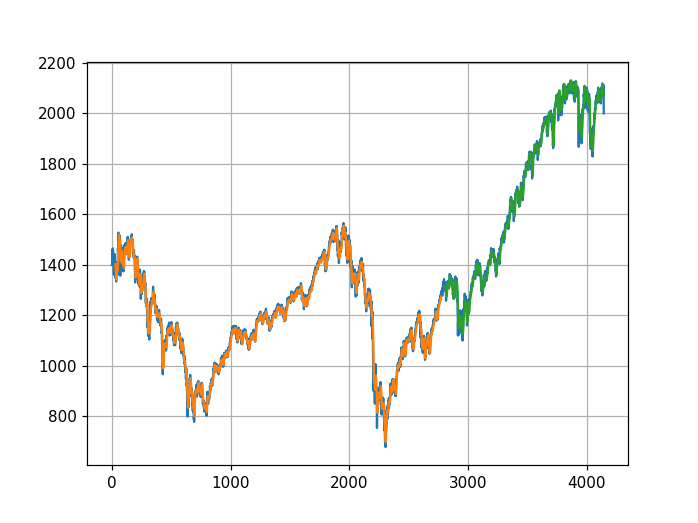

In [19]:
model=make_model(dt_back=dt_back)

model.fit(trainX, trainY, epochs=5, batch_size=11, verbose=2)   # , epochs=5

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
p_train_pred_t = scaler.inverse_transform(trainPredict); trainY1 = scaler.inverse_transform([trainY]);
p_test_pred_t = scaler.inverse_transform(testPredict);   testY1 = scaler.inverse_transform([testY]);

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY1[0], p_train_pred_t[:,0]))
testScore = math.sqrt(mean_squared_error(testY1[0], p_test_pred_t[:,0]))

print('-----------')    # '\n'
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))
    
# shift train predictions for plotting
p_train_pred_pl_t = np.empty_like(p_t)
p_train_pred_pl_t[:, :] = np.nan
p_train_pred_pl_t[dt_back:len(p_train_pred_t)+dt_back, :] = p_train_pred_t

# shift test predictions for plotting
p_test_pred_pl_t = np.empty_like(p_t)
p_test_pred_pl_t[:, :] = np.nan
p_test_pred_pl_t[len(p_train_pred_t)+(dt_back*2)+1:len(p_t)-1, :] = p_test_pred_t

trainY2 = np.reshape(trainY1,(trainY1.shape[1],trainY1.shape[0]))   #np.array(trainY1)   #.shape

p_pl_t=scaler.inverse_transform(p_t)

# plot baseline and predictions
fig1 = plt.figure()

plt.plot(p_pl_t)   # (trainY2)   # [2700:2900]
plt.plot(p_train_pred_pl_t)   #(p_train_pred_t)    # [2700:2900]
plt.plot(p_test_pred_pl_t)    # [2700:2900]
plt.grid()
plt.show()

In [68]:
# one-layer LSTM
def make_model_1(dt_back=10):    # ,batch_size=11  # batch_input_shape=(batch_size,dt_back,1)
    print('=== Model: n_layer=',1,', dt_back=',dt_back,' ===')
    
    model = Sequential()
    model.add(LSTM(100,input_shape=(dt_back,1)))   # input_shape=(1, dt_back)  , activation='relu')
    model.add(Dense(1))                             # , activation='sigmoid'
    model.compile(loss='mean_squared_error', optimizer='adam')   # loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']
    
    return model
# end def make_model():

# two-layer LSTM
def make_model_2(dt_back=10):    # ,batch_size=11, batch_input_shape=(batch_size,dt_back,1)
    print('=== Model: n_layer=',2,', dt_back=',dt_back,' ===')
    
    model = Sequential()
    model.add(LSTM(100,input_shape=(dt_back,1),return_sequences=True))   # input_shape=(dt_back,1)  , activation='relu')    
    model.add(Dropout(0.2))
    
    model.add(LSTM(100,input_shape=(dt_back,1),return_sequences=False))
    #model.add(Dropout(0.2))
    
    model.add(Dense(1))                             # , activation='sigmoid'        
    model.compile(loss='mean_squared_error', optimizer='adam')   # loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']
    
    return model
# end def make_model():

# three-layer LSTM
def make_model_3(dt_back=10):    # ,batch_size=11, batch_input_shape=(batch_size,dt_back,1)
    print('=== Model: n_layer=',3,', dt_back=',dt_back,' ===')
    
    mdl = Sequential()
    mdl.add(LSTM(100,input_shape=(dt_back,1),return_sequences=True))   # input_shape=(dt_back,1)  , activation='relu')    
    mdl.add(Dropout(0.2))
    
    mdl.add(LSTM(100,return_sequences=True))     # ,input_shape=(dt_back,1),return_sequences=False
    mdl.add(Dropout(0.2))
    mdl.add(LSTM(100))     # ,input_shape=(dt_back,1),return_sequences=False
    #mdl.add(Dropout(0.2))    
    
    mdl.add(Dense(1))                             # , activation='sigmoid'        
    mdl.compile(loss='mean_squared_error', optimizer='adam')   # loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']
    
    return mdl
# end def make_model():

def make_model_4(dt_back=10):    # ,batch_size=11, batch_input_shape=(batch_size,dt_back,1)
    print('=== Model: n_layer=',4,', dt_back=',dt_back,' ===')
    
    mdl = Sequential()
    mdl.add(LSTM(100,input_shape=(dt_back,1),return_sequences=True))   # input_shape=(dt_back,1)  , activation='relu')    
    mdl.add(Dropout(0.2))    
    mdl.add(LSTM(100,return_sequences=True))     # ,input_shape=(dt_back,1),return_sequences=False
    mdl.add(Dropout(0.2))
    mdl.add(LSTM(100,return_sequences=True))     # ,input_shape=(dt_back,1),return_sequences=False
    mdl.add(Dropout(0.2))

    mdl.add(LSTM(100))     # ,input_shape=(dt_back,1),return_sequences=False        
    mdl.add(Dense(1))                             # , activation='sigmoid'        
    mdl.compile(loss='mean_squared_error', optimizer='adam')   # loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']
    
    return mdl
# end def make_model():

def make_model_5(dt_back=10):    # ,batch_size=11, batch_input_shape=(batch_size,dt_back,1)
    print('=== Model: n_layer=',5,', dt_back=',dt_back,' ===')
    
    mdl = Sequential()
    mdl.add(LSTM(100,input_shape=(dt_back,1),return_sequences=True))   # input_shape=(dt_back,1)  , activation='relu')    
    mdl.add(Dropout(0.2))    
    mdl.add(LSTM(100,return_sequences=True))     # ,input_shape=(dt_back,1),return_sequences=False
    mdl.add(Dropout(0.2))
    mdl.add(LSTM(100,return_sequences=True))     # ,input_shape=(dt_back,1),return_sequences=False
    mdl.add(Dropout(0.2))
    mdl.add(LSTM(100,return_sequences=True))     # ,input_shape=(dt_back,1),return_sequences=False
    mdl.add(Dropout(0.2))

    mdl.add(LSTM(100))     # ,input_shape=(dt_back,1),return_sequences=False        
    mdl.add(Dense(1))                             # , activation='sigmoid'        
    mdl.compile(loss='mean_squared_error', optimizer='adam')   # loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']
    
    return mdl
# end def make_model():

def train_model(make_model,nlayer,trainX,trainY,testX,testY,dt_back,epochs=5,batch_size=11):
    # make the model for training
    model=make_model(dt_back=dt_back)   # ,batch_size=11

    model.fit(trainX, trainY, epochs=5, batch_size=11, verbose=2)   # , epochs=5

    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    # invert predictions
    p_train_pred_t = scaler.inverse_transform(trainPredict); trainY1 = scaler.inverse_transform([trainY]);
    p_test_pred_t = scaler.inverse_transform(testPredict);   testY1 = scaler.inverse_transform([testY]);

    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY1[0], p_train_pred_t[:,0]))
    testScore = math.sqrt(mean_squared_error(testY1[0], p_test_pred_t[:,0]))

    print('-----------')    # '\n'
    print('Train Score: %.2f RMSE' % (trainScore))
    print('Test Score: %.2f RMSE' % (testScore))
    
    return model,p_train_pred_t,p_test_pred_t
#end def train_model()

def train_plot_model(p_t,make_model,nlayer,train,test,dt_back,epochs=5,batch_size=11):

    trainX, trainY = create_dataset(train, dt_back);  testX, testY = create_dataset(test, dt_back);
    
    # make the model for training
    model=make_model(dt_back=dt_back)   # ,batch_size=11

    model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=0)   # , epochs=5

    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    # invert predictions
    p_train_pred_t = scaler.inverse_transform(trainPredict); trainY1 = scaler.inverse_transform([trainY]);
    p_test_pred_t = scaler.inverse_transform(testPredict);   testY1 = scaler.inverse_transform([testY]);

    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY1[0], p_train_pred_t[:,0]))
    testScore = math.sqrt(mean_squared_error(testY1[0], p_test_pred_t[:,0]))

    #print('-----------')    # '\n'
    #print('Train Score: %.2f RMSE' % (trainScore))
    #print('Test Score: %.2f RMSE' % (testScore))
  
    # shift train predictions for plotting; "pl"=plot, "pred"=prediction
    p_train_pred_pl_t = np.empty_like(p_t)
    p_train_pred_pl_t[:, :] = np.nan
    p_train_pred_pl_t[dt_back:len(p_train_pred_t)+dt_back, :] = p_train_pred_t

    # shift test predictions for plotting
    p_test_pred_pl_t = np.empty_like(p_t)
    p_test_pred_pl_t[:, :] = np.nan
    p_test_pred_pl_t[len(p_train_pred_t)+(dt_back*2)+1:len(p_t)-1, :] = p_test_pred_t

    trainY2 = np.reshape(trainY1,(trainY1.shape[1],trainY1.shape[0]))   #np.array(trainY1)   #.shape

    p_pl_t=scaler.inverse_transform(p_t)    
    
    # plot prediction errors
    fig2 = plt.figure()

    plt.plot(p_pl_t-p_train_pred_pl_t,color='orange')   # (trainY2)   # [2700:2900]
    plt.plot(p_pl_t-p_test_pred_pl_t,color='green') 
    #plt.plot(p_train_pred_pl_t)   #(p_train_pred_t)    # [2700:2900]
    #plt.plot(p_test_pred_pl_t)    # [2700:2900]
    
    s_score='Train/Test: %.2f/%.2f RMSE' % (trainScore,testScore);
    s_title='LSTM [N_layers=' + str(nlayer) + ', dt=' + str(dt_back) + '], ' + s_score
    plt.title(s_title)
    plt.ylabel('1-day Prediction Error ($)')
    plt.xlabel('Time') 

    plt.grid()
    plt.show()
    
    return model,p_train_pred_t,p_test_pred_t
#end def

=== Model: n_layer= 1 , dt_back= 30  ===


<IPython.core.display.Javascript object>


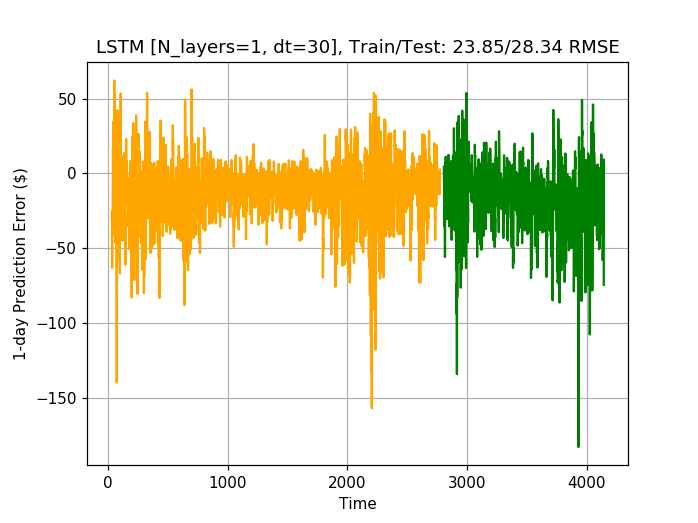

(<keras.models.Sequential at 0x9d1548d0>, array([[ 1418.84301758],
        [ 1413.47668457],
        [ 1409.0715332 ],
        ..., 
        [ 1284.95141602],
        [ 1288.07836914],
        [ 1290.56738281]], dtype=float32), array([[ 1326.37390137],
        [ 1328.8684082 ],
        [ 1329.91967773],
        ..., 
        [ 2102.73364258],
        [ 2103.99707031],
        [ 2111.72827148]], dtype=float32))

In [69]:
dt_back=30
train_plot_model(p_t,eval('make_model_' + str(1)),1,train,test,dt_back,epochs=5,batch_size=11)

In [76]:
depoch=5 
dt_back_n=[30,50,100]
nlayer_n=[1,2,3,4,5]
nt_back=dt_back_n.index(dt_back)
#print(nt_back)

for nlayer in nlayer_n:    
    for dt_back in dt_back_n:
        nt_back=dt_back_n.index(dt_back) + 1   # dt_back-loop iteration nr
        nepoch=5 + (nlayer-1)*depoch + (nt_back-1)*depoch
        #print(nlayer,dt_back,nt_back,nepoch)
        # end for dt_back
# end for nlayer 

=== Model: n_layer= 1 , dt_back= 30  ===


<IPython.core.display.Javascript object>


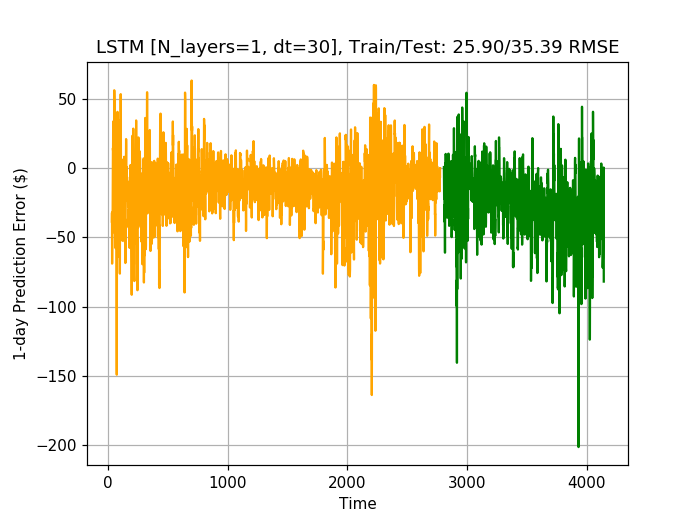

=== Model: n_layer= 1 , dt_back= 50  ===


<IPython.core.display.Javascript object>


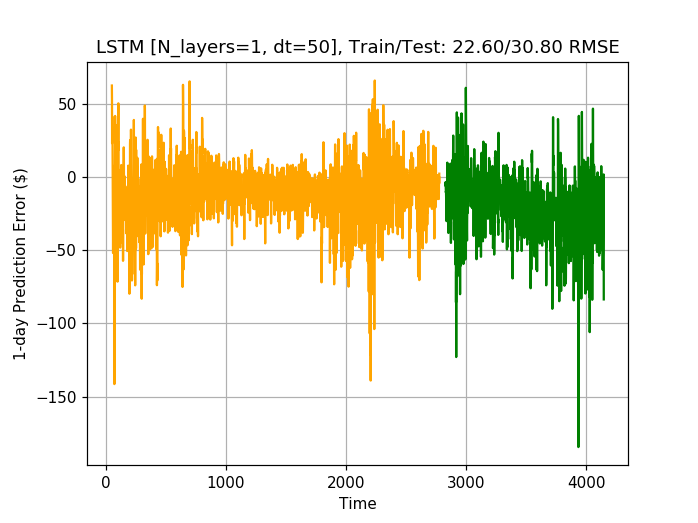

=== Model: n_layer= 1 , dt_back= 100  ===


<IPython.core.display.Javascript object>


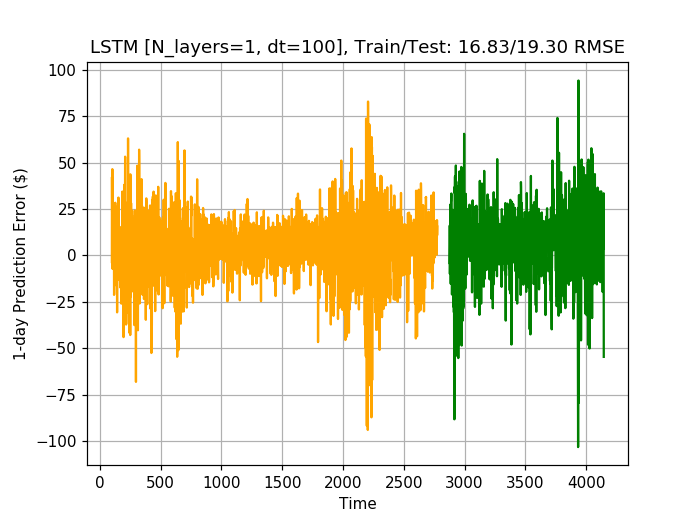

=== Model: n_layer= 2 , dt_back= 30  ===


<IPython.core.display.Javascript object>


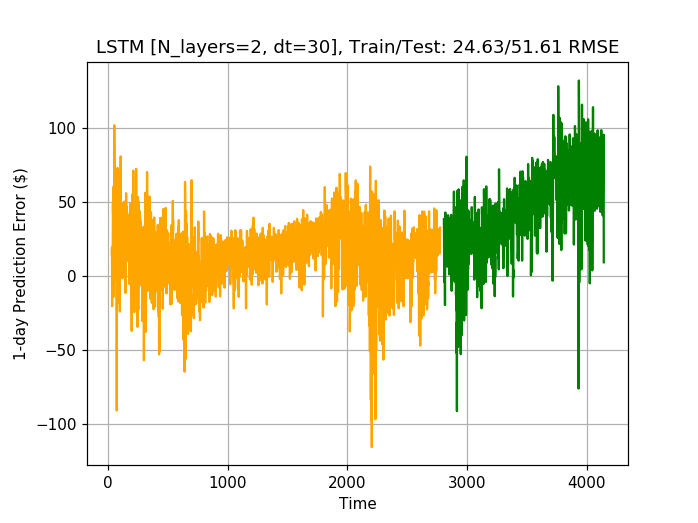

=== Model: n_layer= 2 , dt_back= 50  ===


<IPython.core.display.Javascript object>


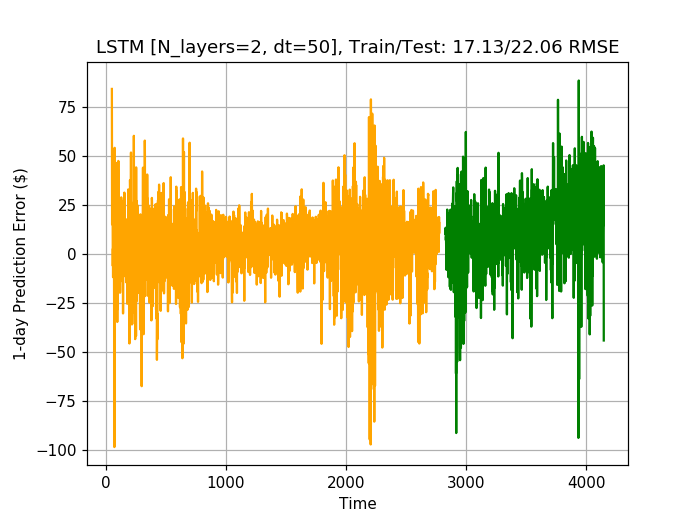

=== Model: n_layer= 2 , dt_back= 100  ===


<IPython.core.display.Javascript object>


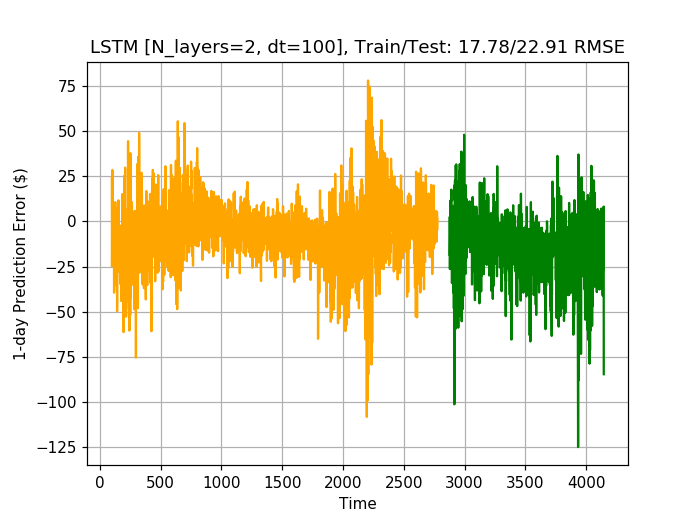

=== Model: n_layer= 3 , dt_back= 30  ===


<IPython.core.display.Javascript object>


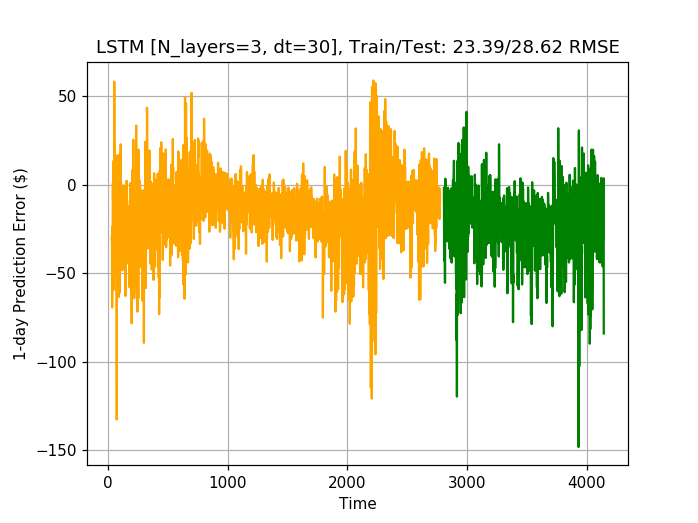

=== Model: n_layer= 3 , dt_back= 50  ===


<IPython.core.display.Javascript object>


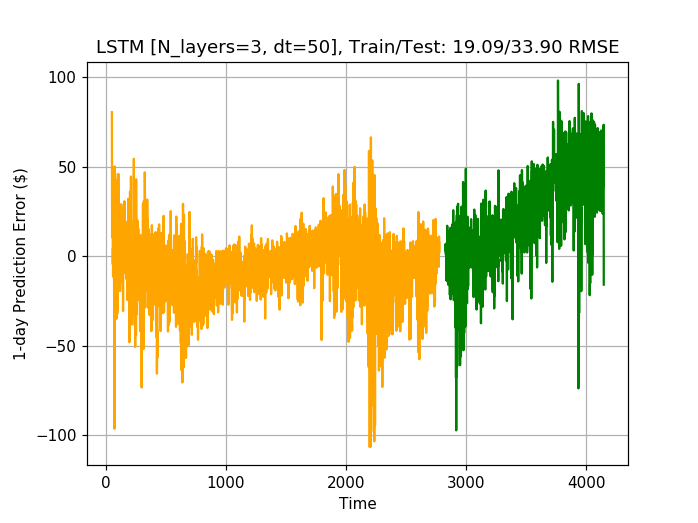

=== Model: n_layer= 3 , dt_back= 100  ===


<IPython.core.display.Javascript object>


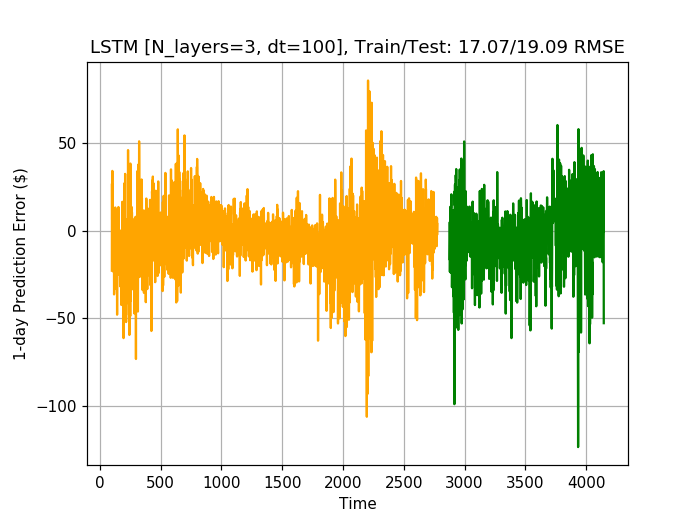

=== Model: n_layer= 4 , dt_back= 30  ===


<IPython.core.display.Javascript object>


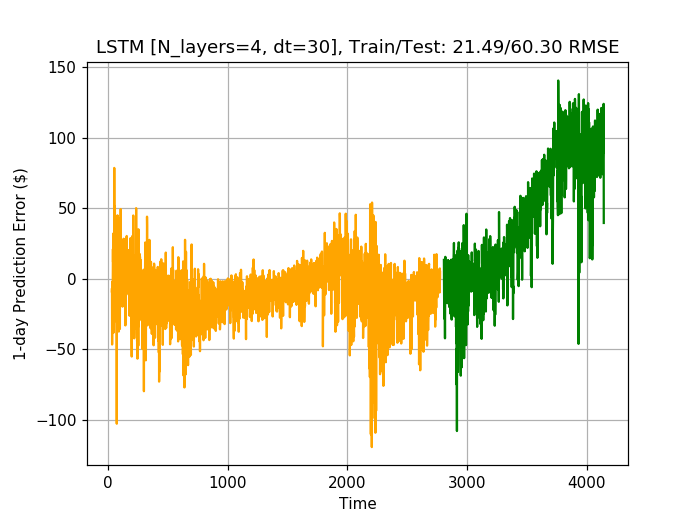

=== Model: n_layer= 4 , dt_back= 50  ===


<IPython.core.display.Javascript object>


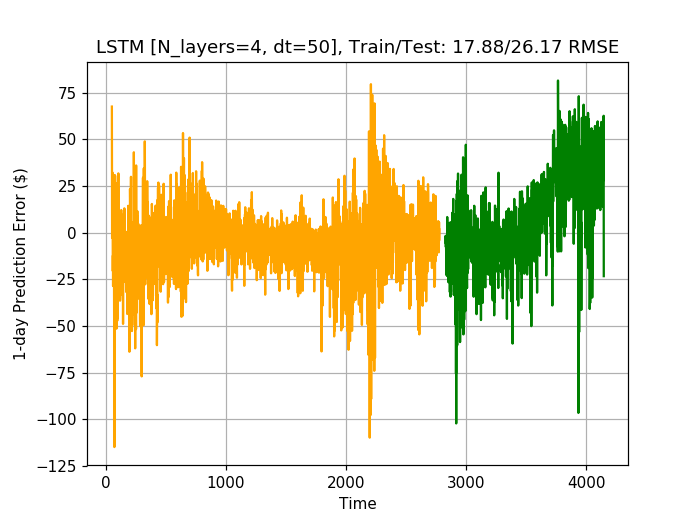

=== Model: n_layer= 4 , dt_back= 100  ===


<IPython.core.display.Javascript object>


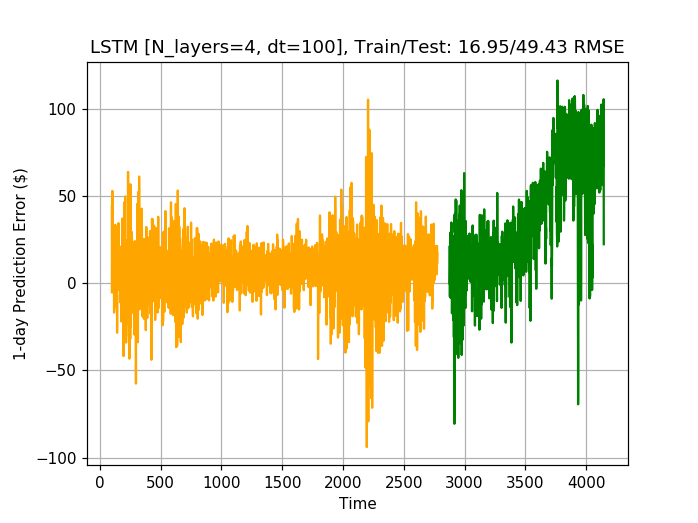

=== Model: n_layer= 5 , dt_back= 30  ===


<IPython.core.display.Javascript object>


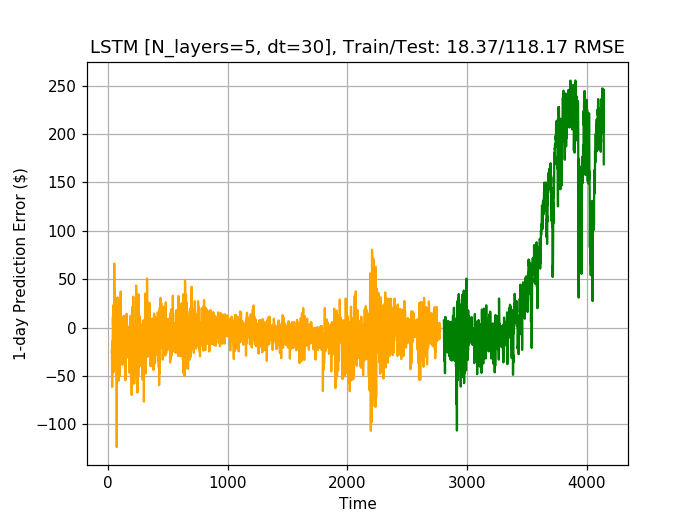

=== Model: n_layer= 5 , dt_back= 50  ===


<IPython.core.display.Javascript object>


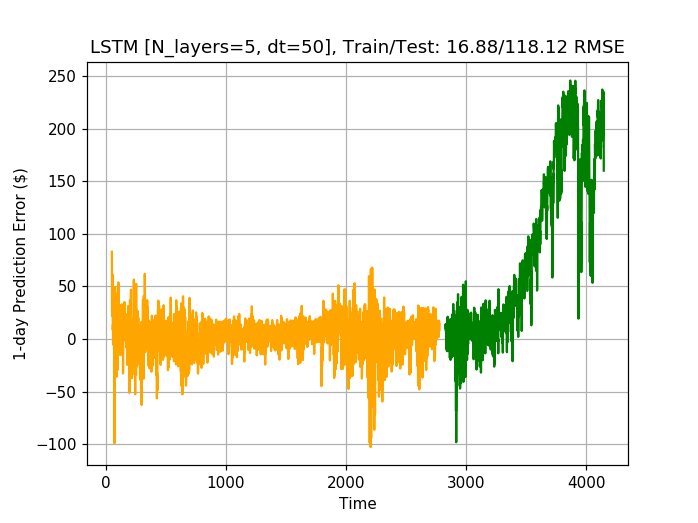

=== Model: n_layer= 5 , dt_back= 100  ===


<IPython.core.display.Javascript object>


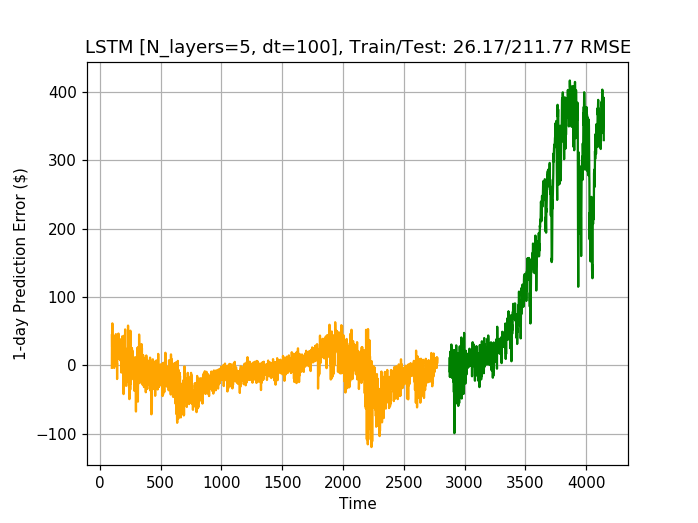

In [77]:
# compare different dt_back values for each nlayer value of the LSTM model
depoch=5    # roughly, increase by this amount for each complexity (either nlayer or dt_back) step in the loops
dt_back_n=[30,50,100]
nlayer_n=[1,2,3,4,5]
        
for nlayer in nlayer_n:    
    for dt_back in dt_back_n:
        nt_back=dt_back_n.index(dt_back) + 1   # dt_back-loop iteration nr
        nepoch=5 + (nlayer-1)*depoch + (nt_back-1)*depoch
        train_plot_model(p_t,eval('make_model_' + str(nlayer)),nlayer,train,test,dt_back,epochs=nepoch,batch_size=11)
    # end for dt_back
# end for nlayer    


=== Model: n_layer= 5 , dt_back= 30  ===
Epoch 1/15
23s - loss: 0.0038
Epoch 2/15
18s - loss: 0.0011
Epoch 3/15
18s - loss: 8.5120e-04
Epoch 4/15
18s - loss: 7.0178e-04
Epoch 5/15
18s - loss: 6.5406e-04
Epoch 6/15
18s - loss: 5.8423e-04
Epoch 7/15
18s - loss: 5.1959e-04
Epoch 8/15
18s - loss: 4.3145e-04
Epoch 9/15
18s - loss: 4.6173e-04
Epoch 10/15
18s - loss: 4.4754e-04
Epoch 11/15
18s - loss: 4.1631e-04
Epoch 12/15
18s - loss: 3.8435e-04
Epoch 13/15
18s - loss: 3.3357e-04
Epoch 14/15
18s - loss: 3.3996e-04
Epoch 15/15
18s - loss: 3.5979e-04
-----------
Train Score: 22.73 RMSE
Test Score: 68.18 RMSE


<IPython.core.display.Javascript object>


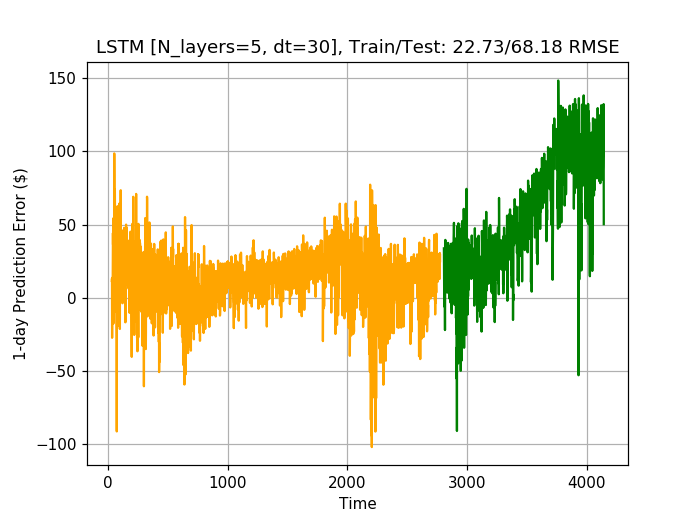

=== Model: n_layer= 5 , dt_back= 50  ===
Epoch 1/15
36s - loss: 0.0035
Epoch 2/15
30s - loss: 9.7835e-04
Epoch 3/15
30s - loss: 7.6663e-04
Epoch 4/15
29s - loss: 6.9031e-04
Epoch 5/15
29s - loss: 5.8872e-04
Epoch 6/15
29s - loss: 5.5229e-04
Epoch 7/15
29s - loss: 5.9143e-04
Epoch 8/15
30s - loss: 5.0274e-04
Epoch 9/15
29s - loss: 3.7350e-04
Epoch 10/15
29s - loss: 4.0225e-04
Epoch 11/15
29s - loss: 3.6595e-04
Epoch 12/15
29s - loss: 4.1879e-04
Epoch 13/15
29s - loss: 3.7346e-04
Epoch 14/15
29s - loss: 3.2503e-04
Epoch 15/15
29s - loss: 3.8334e-04
-----------
Train Score: 21.66 RMSE
Test Score: 27.94 RMSE


<IPython.core.display.Javascript object>


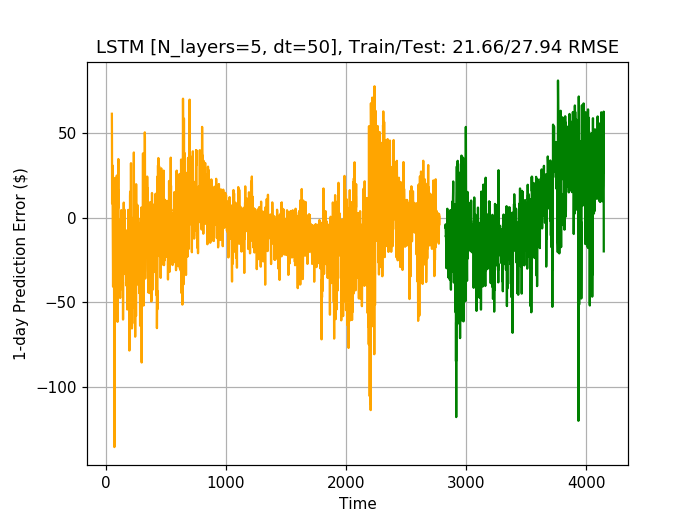

(<keras.models.Sequential at 0x7a934208>, array([[ 1397.11364746],
        [ 1420.03869629],
        [ 1448.29711914],
        ..., 
        [ 1283.81518555],
        [ 1288.22802734],
        [ 1292.73730469]], dtype=float32), array([[ 1331.79638672],
        [ 1336.41235352],
        [ 1340.7298584 ],
        ..., 
        [ 2048.66113281],
        [ 2050.71289062],
        [ 2057.3762207 ]], dtype=float32))

In [62]:
# compare different parameters for the same model
dt_back=30
train_plot_model(p_t,eval('make_model_' + str(5)),5,train,test,dt_back,epochs=15,batch_size=11)

dt_back=50
train_plot_model(p_t,eval('make_model_' + str(5)),5,train,test,dt_back,epochs=15,batch_size=11)

=== Model: n_layer= 5 , dt_back= 50  ===


<IPython.core.display.Javascript object>


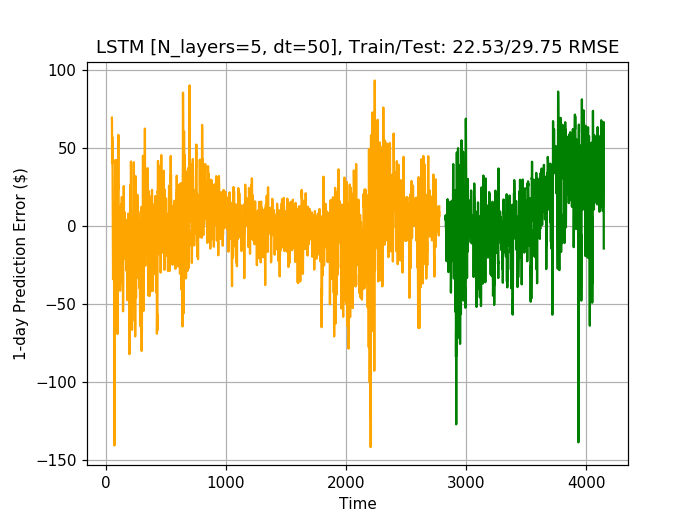

(<keras.models.Sequential at 0x1016969b0>, array([[ 1389.14489746],
        [ 1397.89868164],
        [ 1416.57824707],
        ..., 
        [ 1276.46447754],
        [ 1277.91333008],
        [ 1280.70227051]], dtype=float32), array([[ 1321.69702148],
        [ 1325.60168457],
        [ 1329.35925293],
        ..., 
        [ 2044.2947998 ],
        [ 2046.82775879],
        [ 2051.89770508]], dtype=float32))

In [78]:
dt_back=50
train_plot_model(p_t,eval('make_model_' + str(5)),5,train,test,dt_back,epochs=10,batch_size=11)

Prediction errors show that, the LSTM model partially captures volatility clustering effects!

In [60]:
#train_plot_model(p_t,make_model_2,2,trainX,trainY,testX,testY,100,epochs=5,batch_size=11)